In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os 
import random
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torch.utils.data import Dataset

In [ ]:
def unnormalize(img):
  img = (img/2)+0.5 
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

def decode_label(label):
  actions=trainloader.dataset.classes
 # actions = ['Batata Vada', 'Chowmein', 'Hakka Noodles', 'Manchurian', 'Medu Vada', 'Mirch Pakoda','Mirch Pakoda','Onion Pakoda','Pasta','Sabudana Vada','Sweet pethas','Tandoori Fish Tikka','Vegetable jalfrezi','White Sauce Pasta','zarda (food)']
  return actions[label]

In [ ]:
traindir = '/content/drive/My Drive/Naaniz/Indian Dishes'
#validdir = '/content/drive/My Drive/Train/train/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(0.4),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])
    test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = datasets.ImageFolder(traindir, transform=train_transforms)
    test_data = datasets.ImageFolder(traindir, transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler, num_workers=8, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,sampler=test_sampler,num_workers=8,batch_size=64)
    return trainloader, testloader


trainloader, validloader = load_split_train_test(traindir, .2)

(259, 194)


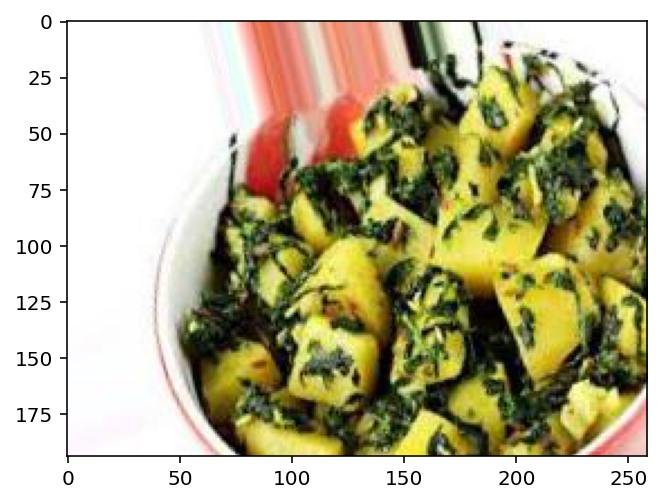

In [ ]:
img = Image.open("/content/drive/My Drive/Indian Dishes/Aloo methi/aloo_methi_0_1036.jpeg")
print(img.size)
plt.imshow(img)

In [ ]:
print("Classes: ", len(trainloader.dataset.classes),trainloader.dataset.classes)

Classes:  231 ['Aloo methi', 'Aloo_Shimala_Mirch', 'Aloo_tikki', 'Amritsari Fish', 'Amritsari_Kulcha', 'Ankuri', 'Attu', 'Baby_corn_chilly', 'Basundi', 'Batata Vada', 'Besan_ke_ladoo', 'Bhakhri', 'Bhindi', 'Boondi_ke_Ladoo', 'Chandrakala', 'Chicken Tikka Masala', 'Chowmein', 'Corn_Chaat', 'Daal Baati Churma', 'Daal Puri', 'Daal_Makhni', 'Daal_Tadka', 'Dabeli', 'Dibba rotti', 'Everyday Yellow Dal', 'Firni', 'Fish head curry', 'French Bean Aloo', 'Gajar Matar', 'Gajar_Halwa', 'Ghevar', 'Gobhi Matar', 'Hakka Noodles', 'Imarti   Jalebi', 'Kaali_Daal', 'Kadhi Pakora', 'Kalakand', 'Karanji(gujiya)', 'Karela Bharta', 'Lauki_kaufte', 'Litti chokha', 'Malpua', 'Manchurian', 'Mathura ka Peda', 'Medu Vada', 'Milkcake', 'Missi Roti', 'Mix Veg', 'Momos', 'Moong Dal ka Halwa', 'Mushroom Do Payaza', 'Mushroom Matar', 'Nariyal_ke_ladoo', 'Navaratan Korma', 'Onion Pakoda', 'Pakhala', 'Paneer butter masala', 'Panjeeri', 'Papad', 'Pasta', 'Payasam', 'Pindi chana', 'Pinni', 'Rajma chaval', 'Ramatori subji

torch.Size([3, 224, 224])


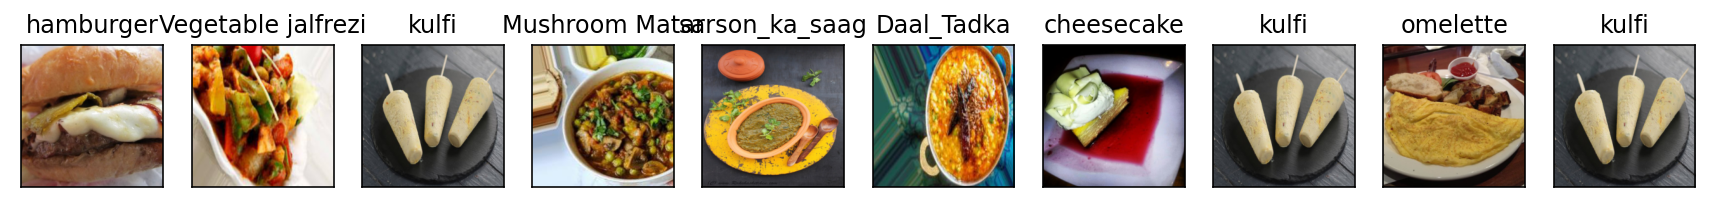

In [ ]:
batch = next(iter(trainloader))

imgs = []
actions = []
for i in range(10):
  sample = random.randint(0, 63)
  img =  unnormalize(batch[0][sample])
  action = decode_label(int(batch[1][sample]))
  imgs.append(img)
  actions.append(action)

print(batch[0][0].shape)
plot_imgs(imgs, actions, (15,15))

In [ ]:
class mobileNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    def separableConv2d(in_channels, out_channels, kernel_size):
      
      return nn.Sequential(nn.Conv2d(in_channels,  in_channels, kernel_size, groups=in_channels),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(in_channels),
                      
                           nn.Conv2d(in_channels, out_channels, 1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(out_channels))
    
    
    self.conv1 = separableConv2d(3, 16, 3) 
    self.conv2 = separableConv2d(16, 32, 3)
    self.conv3 = separableConv2d(32, 64, 3)
    self.conv4 = separableConv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear(2*2*128, 1024)
    self.fc2 = nn.Linear(1024, 231)
    
  def forward(self, x):
    
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    x = self.pool(self.conv3(x))
    x = self.pool(self.conv4(x))
    
    x = x.view(x.size()[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    return x

In [ ]:
def validation(model, validloader, criterion):
  correct = 0
  total = 0
  for minibatch, batch in enumerate(validloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision.models as models
model =  models.resnet50(pretrained=True)
saved_file2 = "/content/drive/My Drive/Naaniz/fulltrained5.pth"
saved_file = "/content/drive/My Drive/Naaniz/lessloss5.pth"
state_dict = torch.load(saved_file)
model.load_state_dict(state_dict)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

In [ ]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs =1
print_every = 50

In [ ]:
best = 100

for epoch in range(epochs):
  for minibatch, batch in enumerate(trainloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if minibatch % print_every == 0:
      model.eval()
      with torch.no_grad():
        accuracy = validation(model, validloader, criterion)
        training_loss = loss.item()
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Loss: {:.5f}.. ".format(training_loss),
              "Accuracy: {}.. ".format(accuracy))
        if best > training_loss:
          torch.save(model.state_dict(), "/content/drive/My Drive/Naaniz/lessloss5.pth")
          best = training_loss
      model.train()
      torch.save(model.state_dict(), "/content/drive/My Drive/Naaniz/fulltrained5.pth")

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8e4fcac518>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8e4fcac518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8e4fcac518>>
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python

KeyboardInterrupt: ignored

In [ ]:
saved_file2 = "/content/drive/My Drive/Naaniz/fulltrained5.pth"
saved_file = "/content/drive/My Drive/Naaniz/lessloss5.pth"
state_dict = torch.load(saved_file)
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
  acc = validation(model, validloader, criterion)
  print("Validation accuracy: ", acc)

KeyboardInterrupt: ignored

In [ ]:
class_correct = list(0. for i in range(231))
class_total = list(0. for i in range(231))

with torch.no_grad():
  for minibatch, batch in enumerate(validloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    
    for sample in range(231):
      try:
        label = labels[sample]
        class_correct[label] += c[sample].item()
        class_total[label] += 1
      except:
        break
      
for i in range(231):
  print("Accuracy of %5s : %2d %%" % (decode_label(i), 100*class_correct[i]/class_total[i]))

In [ ]:

def get_data(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append(os.path.join(path, file))
      total += 1
  return data, total


test_data, total = get_data("/content/drive/My Drive/Naaniz/test")

In [ ]:
print("Test sample: ", test_data[0], " Total samples: ", total)

In [ ]:
class intelImageClassification(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform
    
  def __getitem__(self, index):
    img = self.data[index]
    img_name = img[31:]
    
    img = Image.open(img)
    
    if self.transform is not None:
      img = self.transform(img)
    
    return img, img_name
  
  def __len__(self):
    return len(self.data)

In [ ]:

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_dataset = intelImageClassification(test_data, transform = test_transforms)
testloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, num_workers=8, batch_size=64)

In [ ]:


batch = next(iter(testloader))
sample = random.randint(0,64)
img = unnormalize(batch[0][sample])
img_name = batch[1][sample]

print(img.shape)
plot_imgs([img], [img_name], (5,5))

In [ ]:
import cv2 
import matplotlib.image as mpimg

def imshow(img, text=None, name=None):
  npimg = img.cpu().numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  npimg = cv2.resize(npimg, dsize=(150, 150))
  plt.axis("off")
  if text: 
    plt.text(30, 16, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8})
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.imshow(npimg)
  
  name = name + ".jpg"
  #plt.savefig("./preds/"+name)
  plt.show() 

with torch.no_grad():
  for minibatch, batch in enumerate(testloader):
    images, names = batch[0].to(device), batch[1]
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    
    for i in range(72):
      label = decode_label(predictions[i].cpu().numpy())
      imshow(images[i], label, str(i))
    
    break

NameError: ignored